In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Data Source
# https://www.kaggle.com/kimjihoo/coronavirusdataset?select=SeoulFloating.csv

import plotly.express as px
px.set_mapbox_access_token(open("./mapbox_token").read())
# pip install plotly_express==0.4.0

from warnings import filterwarnings
filterwarnings('ignore')

# Data Overview

# 1.1) Case

## 1.1.1) Overview of the cases in Korea

In [53]:
caseData = pd.read_csv('covid/case.csv')
caseDataForMap = caseData.copy()
caseDataForMap = caseDataForMap[caseDataForMap[['latitude', 'longitude']] != '-']

cols = ['latitude', 'longitude']
caseData[cols] = caseData[cols].apply(pd.to_numeric, errors='coerce', axis=1)
# display(caseData.head())

fig = px.scatter_mapbox(
    caseData[caseData.latitude != '-'], 
    text="<br>City: " + caseData["city"] +" <br>Province: " + caseData["province"],
    lat="latitude", 
    lon="longitude",     
    color="confirmed", 
    size="confirmed",
    color_continuous_scale=px.colors.diverging.Spectral,
    size_max=100, 
    zoom=6)
fig.show()

## 1.1.2) Check the relationship between group and solo cases

In [96]:
caseDataCopy = caseData.copy()
display(caseDataCopy['confirmed'].mean())

65.48850574712644

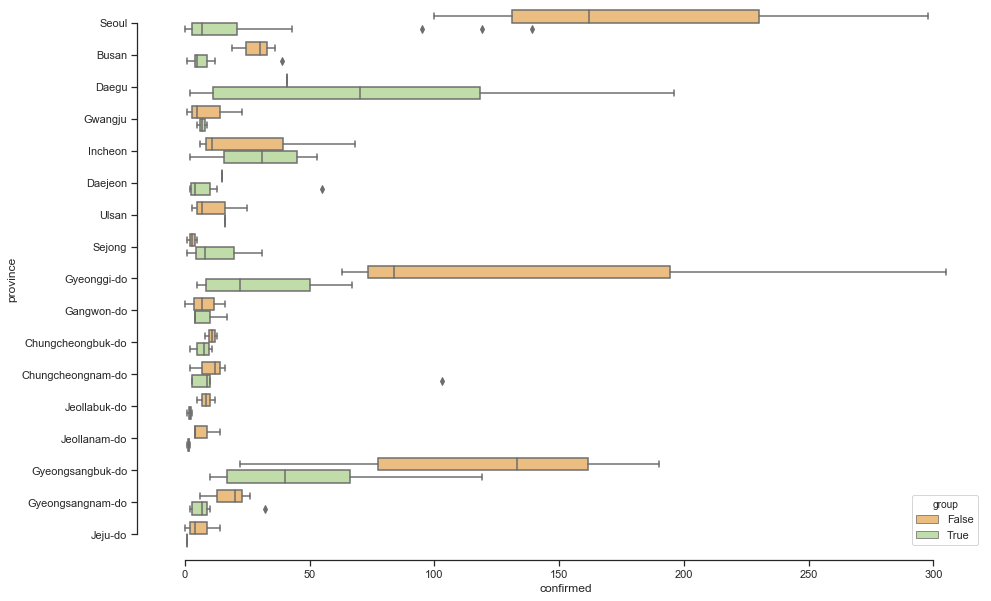

In [98]:
#Remove confirmed 2 cases which are more than 1000 and are in Daegu
#We only want to find out if the cases are group related
caseDataCopy = caseDataCopy[caseDataCopy['confirmed'] < 500] 

f, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x="confirmed", y="province",
            hue="group", palette="Spectral",
            data=caseDataCopy, ax=ax)
sns.despine(offset=10, trim=True)

### 1.1.3) Numbers of cases sort by source and province

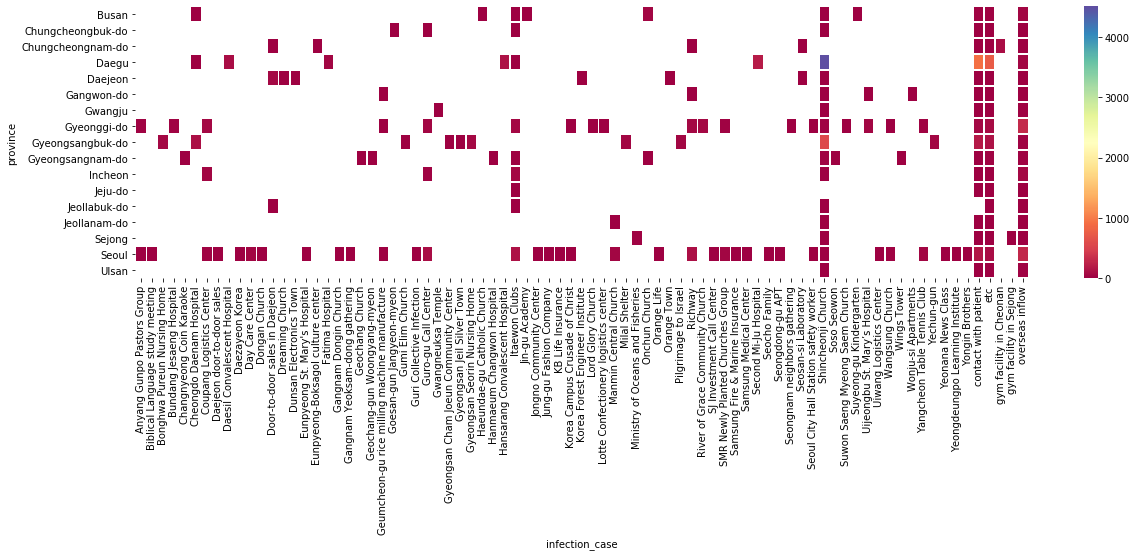

In [5]:
locations = caseData.pivot("province", "infection_case", "confirmed")
f, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(locations, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

## 1.2) Patient Info

### 1.2.1) Numbers Of Cases Per Day

In [75]:
patientData = pd.read_csv('covid/patientinfo.csv')
groupPatientData = patientData.groupby('confirmed_date').size().reset_index()
groupPatientData.columns = ['confirmed_date', 'count']

fig = px.line(groupPatientData, x="confirmed_date", y="count", title='Numbers Of Covid Cases Per Day')
fig.show()

### 1.2.2) Average Survivor Confined Day, Sort by Age & Gender 

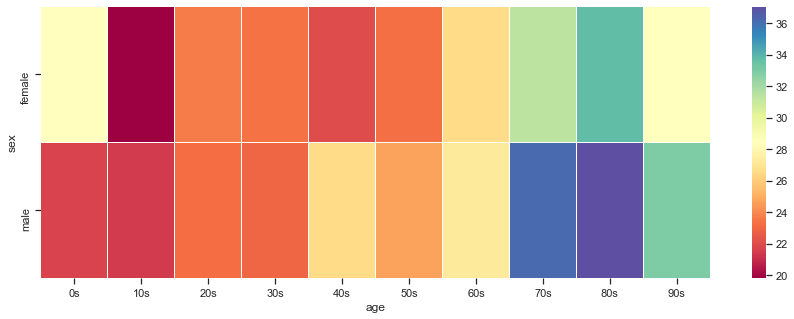

In [87]:
confinedDaysAnalysis = patientData.copy()
confinedDaysAnalysis = confinedDaysAnalysis[confinedDaysAnalysis['age'] != '100s'] #Just a single data which is highly skewed
confinedDaysAnalysis = confinedDaysAnalysis[confinedDaysAnalysis['released_date'].notnull()]

cols = ['released_date', 'confirmed_date']
confinedDaysAnalysis[cols] = confinedDaysAnalysis[cols].apply(pd.to_datetime, errors='coerce', axis=1)
confinedDaysAnalysis['Total Confined Days'] = (confinedDaysAnalysis['released_date'] - confinedDaysAnalysis['confirmed_date']).dt.days

groupedData = confinedDaysAnalysis.groupby(['sex', 'age'])['Total Confined Days'].mean().unstack().stack().reset_index()
groupedData.columns = ["sex", "age", "Average Confined Days"]

dataForHeatmap = groupedData.pivot("sex", "age", "Average Confined Days")
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(dataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

### 1.2.3) Average Survivor Confined Day, Sort by City & Age

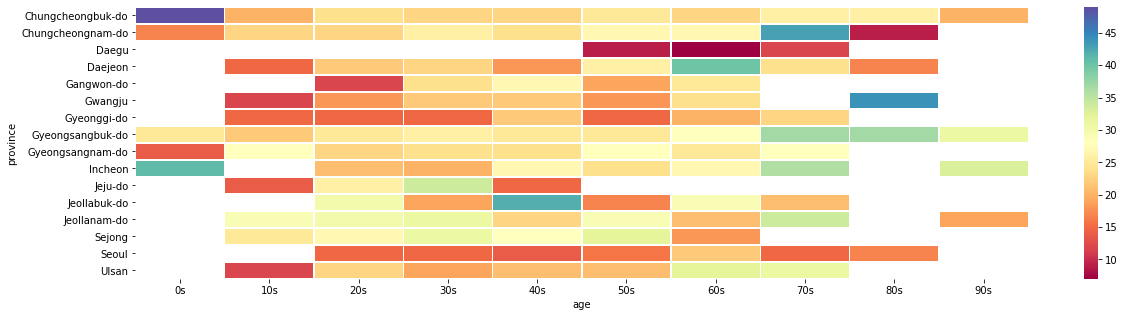

In [8]:
groupedData = confinedDaysAnalysis.groupby(['province', 'age'])['Total Confined Days'].mean().unstack().stack().reset_index()
groupedData.columns = ["province", "age", "Average Confined Days"]
groupedData['Average Confined Days'] = np.ceil(groupedData['Average Confined Days'].apply(pd.to_numeric, errors='coerce'))

dataForHeatmap = groupedData.pivot("province", "age", "Average Confined Days")
f, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(dataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

### 1.2.4) Average Deceased Confined Day, Sort by Age & Gender

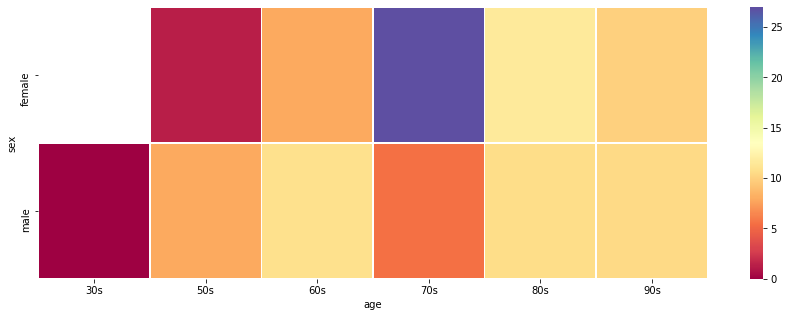

In [9]:
confinedDaysAnalysis = patientData.copy()
confinedDaysAnalysis = confinedDaysAnalysis[confinedDaysAnalysis['age'] != '100s'] #Just a single data which is highly skewed
confinedDaysAnalysis = confinedDaysAnalysis[confinedDaysAnalysis['deceased_date'].notnull()]

cols = ['deceased_date', 'confirmed_date']
confinedDaysAnalysis[cols] = confinedDaysAnalysis[cols].apply(pd.to_datetime, errors='coerce', axis=1)
confinedDaysAnalysis['Total Confined Days'] = (confinedDaysAnalysis['deceased_date'] - confinedDaysAnalysis['confirmed_date']).dt.days

groupedData = confinedDaysAnalysis.groupby(['sex', 'age'])['Total Confined Days'].mean().unstack().stack().reset_index()
groupedData.columns = ["sex", "age", "Average Confined Days"]

dataForHeatmap = groupedData.pivot("sex", "age", "Average Confined Days")
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(dataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

### 1.2.5) Average Deceased Confined Day, Sort by City & Age

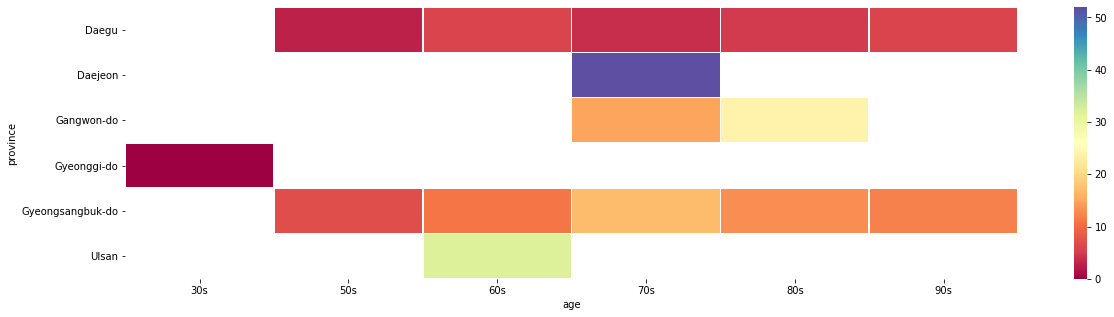

In [10]:
groupedData = confinedDaysAnalysis.groupby(['province', 'age'])['Total Confined Days'].mean().unstack().stack().reset_index()
groupedData.columns = ["province", "age", "Average Confined Days"]
groupedData['Average Confined Days'] = np.ceil(groupedData['Average Confined Days'].apply(pd.to_numeric, errors='coerce'))

dataForHeatmap = groupedData.pivot("province", "age", "Average Confined Days")
f, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(dataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

### 1.2.6) Number of Infection, Survivor, Deceased Per City by percentage

In [11]:
survivorCountAnalysis = patientData.copy()

survivorCountAnalysis['survive'] = survivorCountAnalysis['released_date'].notnull()
survivorCountAnalysis['deceased'] = survivorCountAnalysis['deceased_date'].notnull()
survivorCountAnalysis['under treatment'] = survivorCountAnalysis['deceased_date'].isnull() & survivorCountAnalysis['released_date'].isnull()

provinceStats = survivorCountAnalysis.groupby(['province']).sum()
provinceStatsClean = provinceStats[['survive', 'deceased', 'under treatment']]

provinceStatsClean['survive %'] = np.round(provinceStatsClean['survive'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)
provinceStatsClean['deceased %'] = np.round(provinceStatsClean['deceased'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)
provinceStatsClean['under treatment %'] = np.round(provinceStatsClean['under treatment'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)

provinceStatsAbsolute = provinceStatsClean[['survive', 'deceased', 'under treatment']]
provinceStatsPercentage = provinceStatsClean[['survive %', 'deceased %', 'under treatment %']]

display(provinceStatsAbsolute)
display(provinceStatsPercentage)

,survive,deceased,under treatment
province,,,
Busan,0.0,0.0,151.0
Chungcheongbuk-do,50.0,0.0,6.0
Chungcheongnam-do,150.0,0.0,18.0
Daegu,4.0,20.0,113.0
Daejeon,44.0,1.0,74.0
Gangwon-do,28.0,3.0,32.0
Gwangju,26.0,0.0,18.0
Gyeonggi-do,61.0,1.0,1146.0
Gyeongsangbuk-do,862.0,40.0,354.0


,survive %,deceased %,under treatment %
province,,,
Busan,0.00,0.00,100.00
Chungcheongbuk-do,89.29,0.00,10.71
Chungcheongnam-do,89.29,0.00,10.71
Daegu,2.92,14.60,82.48
Daejeon,36.97,0.84,62.18
Gangwon-do,44.44,4.76,50.79
Gwangju,59.09,0.00,40.91
Gyeonggi-do,5.05,0.08,94.87
Gyeongsangbuk-do,68.63,3.18,28.18


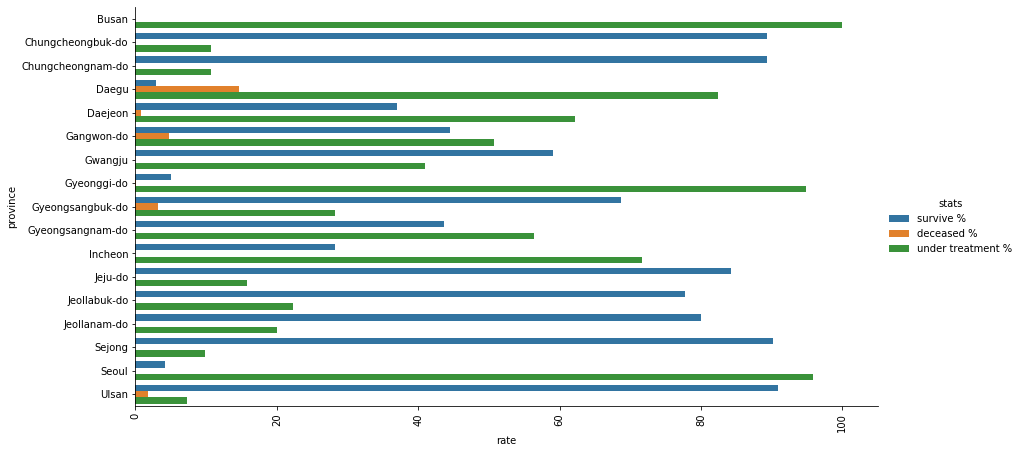

In [12]:
newTable = provinceStatsPercentage.reset_index()
newTable = pd.melt(newTable, id_vars="province", var_name="stats", value_name="rate")

chart = sns.factorplot(x='rate', y='province', hue='stats', data=newTable, kind='bar', height=6.27, aspect=16.7/8.27)
chart.set_xticklabels(rotation=90)

### 1.2.7) Number of Infection, Survivor, Deceased Sort By Gender

In [13]:
survivorCountAnalysis = patientData.copy()

survivorCountAnalysis['survive'] = survivorCountAnalysis['released_date'].notnull()
survivorCountAnalysis['deceased'] = survivorCountAnalysis['deceased_date'].notnull()
survivorCountAnalysis['under treatment'] = survivorCountAnalysis['deceased_date'].isnull() & survivorCountAnalysis['released_date'].isnull()

provinceStats = survivorCountAnalysis.groupby(['sex']).sum()
provinceStatsClean = provinceStats[['survive', 'deceased', 'under treatment']]

provinceStatsClean['survive %'] = np.round(provinceStatsClean['survive'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)
provinceStatsClean['deceased %'] = np.round(provinceStatsClean['deceased'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)
provinceStatsClean['under treatment %'] = np.round(provinceStatsClean['under treatment'] / (provinceStatsClean['survive'] + provinceStatsClean['deceased'] + provinceStatsClean['under treatment']) * 100, 2)

provinceStatsAbsolute = provinceStatsClean[['survive', 'deceased', 'under treatment']]
provinceStatsPercentage = provinceStatsClean[['survive %', 'deceased %', 'under treatment %']]

display(provinceStatsAbsolute)
display(provinceStatsPercentage)

,survive,deceased,under treatment
sex,,,
female,909.0,26.0,1285.0
male,677.0,40.0,1108.0


,survive %,deceased %,under treatment %
sex,,,
female,40.95,1.17,57.88
male,37.10,2.19,60.71


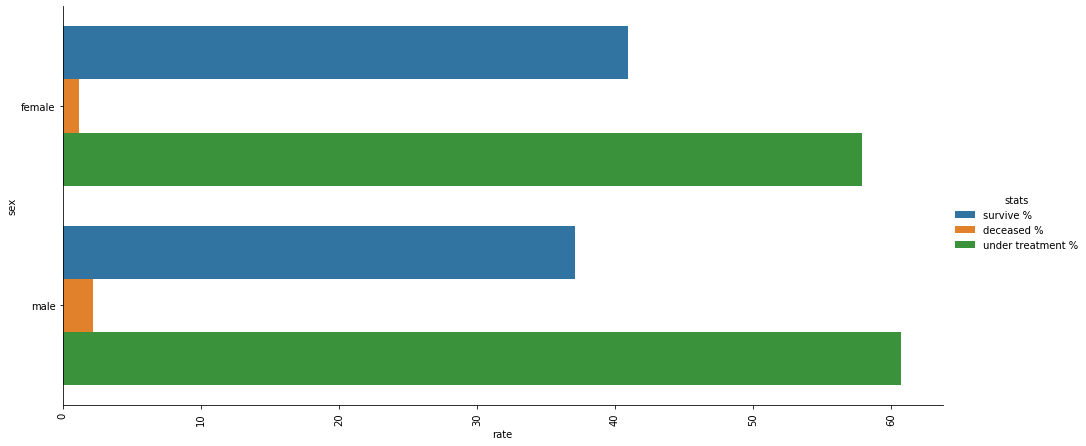

In [14]:
newTable = provinceStatsPercentage.reset_index()
newTable = pd.melt(newTable, id_vars="sex", var_name="stats", value_name="rate")

chart = sns.factorplot(x='rate', y='sex', hue='stats', data=newTable, kind='bar', height=6.27, aspect=17.7/8.27)
chart.set_xticklabels(rotation=90)

### 1.2.8) Network Diagram

In [76]:
networkData = patientData.copy()
networkData = networkData[networkData['infected_by'].notnull()]
networkData = networkData[['patient_id','sex','age','province','city','infection_case','infected_by','state']]
display(networkData.head())

,patient_id,sex,age,province,city,infection_case,infected_by,state
2,1000000003,male,50s,Seoul,Jongno-gu,contact with patient,2002000001,released
4,1000000005,female,20s,Seoul,Seongbuk-gu,contact with patient,1000000002,released
5,1000000006,female,50s,Seoul,Jongno-gu,contact with patient,1000000003,released
6,1000000007,male,20s,Seoul,Jongno-gu,contact with patient,1000000003,released
9,1000000010,female,60s,Seoul,Seongbuk-gu,contact with patient,1000000003,released


In [77]:
import networkx as nx
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

A = list(networkData["infected_by"].unique())
B = list(networkData["patient_id"].unique())
node_list = set(A+B)

# Create Graph
G = nx.Graph()

for i in node_list:
    G.add_node(i)
# G.nodes()

for i,j in networkData.iterrows():
    G.add_edges_from([(j["infected_by"],j["patient_id"])])
    
pos = nx.spring_layout(G, k=0.5, iterations=50)

for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Numnber of Infected Cases',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' # of connections: '+ str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
    
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Korea Covid Network Connections',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

# 1.3) Policy

In [325]:
from datetime import datetime
import plotly.figure_factory as ff

policyData = pd.read_csv('covid/policy.csv')
policyDataCopy = policyData.copy()
policyDataCopy['end_date'] = policyDataCopy['end_date'].fillna(datetime.now().strftime('%Y-%m-%d'))
# display(policyDataCopy.head())

df = []

for index, row in policyDataCopy.iterrows():
    df.append(dict(Task=row['gov_policy'], Start=row['start_date'], Finish=row['end_date'], Resource=row['type']))

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", color="Resource")
fig.show()

patientData = pd.read_csv('covid/patientinfo.csv')
groupPatientData = patientData.groupby('confirmed_date').size().reset_index()
groupPatientData.columns = ['confirmed_date', 'count']

fig = px.line(groupPatientData, x="confirmed_date", y="count", title='Numbers Of Covid Cases Per Day')
fig.show()

# 1.4) Time

In [26]:
timeData = pd.read_csv('covid/time.csv')
timeDataMelted = pd.melt(timeData, id_vars=['date'], value_vars=['test', 'negative','confirmed','released','deceased'])
fig = px.line(timeDataMelted, x="date", y="value", color='variable')
fig.show()

In [27]:
timeDataMelted = pd.melt(timeData, id_vars=['date'], value_vars=['confirmed','released','deceased'])
fig = px.line(timeDataMelted, x="date", y="value", color='variable')
fig.show()

# 1.5) TimeAge

In [41]:
timeAgeData = pd.read_csv('covid/timeage.csv')
fig = px.line(timeAgeData, x="date", y="confirmed", color='age')
fig.show()

In [40]:
timeAgeData = pd.read_csv('covid/timeage.csv')
fig = px.line(timeAgeData, x="date", y="deceased", color='age')
fig.show()

# 1.6) Time Gender

In [43]:
timeGender = pd.read_csv('covid/timegender.csv')
fig = px.line(timeGender, x="date", y="confirmed", color='sex')
fig.show()

In [44]:
fig = px.line(timeGender, x="date", y="deceased", color='sex')
fig.show()

# 1.7) Time Province

In [49]:
timeProvince = pd.read_csv('covid/timeprovince.csv')
fig = px.line(timeProvince, x="date", y="confirmed", color='province')
fig.show()

In [50]:
fig = px.line(timeProvince, x="date", y="released", color='province')
fig.show()

In [51]:
fig = px.line(timeProvince, x="date", y="deceased", color='province')
fig.show()

# 1.8) Weather

,date,code,province,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,2020-01-01,10000,Seoul,-2.2,-6.5,0.3,0.0,2.6,50.0,64.4
1,2020-01-01,11000,Busan,1.9,-3.2,7.8,0.0,5.1,340.0,44.0
2,2020-01-01,12000,Daegu,0.2,-4.9,4.6,0.0,5.6,270.0,53.3
3,2020-01-01,13000,Gwangju,-0.3,-4.9,5.7,0.0,4.3,50.0,58.0
4,2020-01-01,14000,Incheon,-1.4,-5.4,1.9,0.0,3.8,160.0,66.6


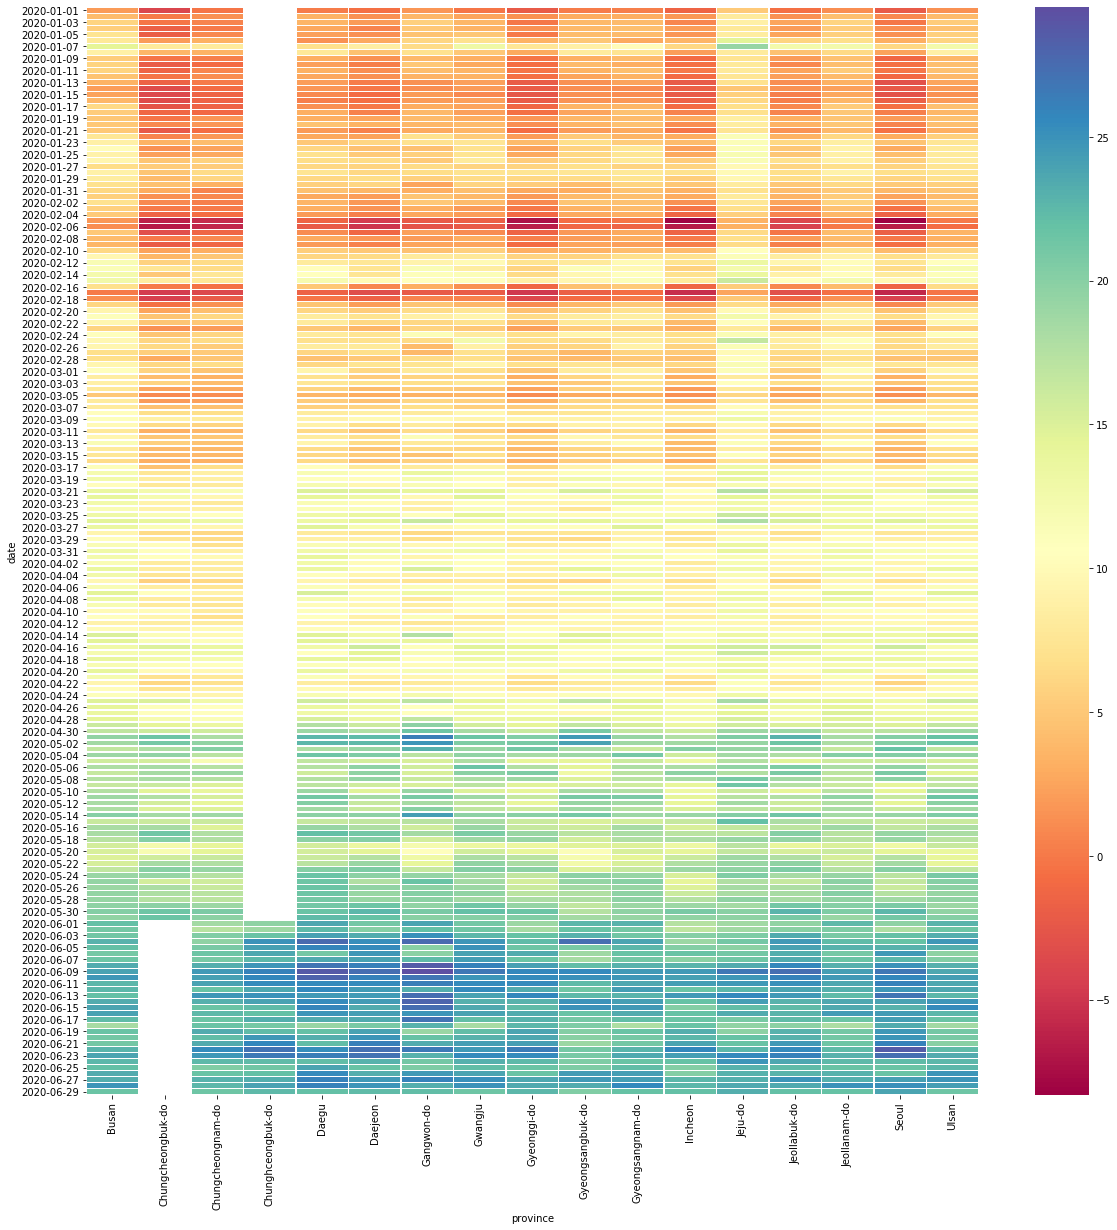

In [64]:
weatherData = pd.read_csv('covid/weather.csv')
weatherData = weatherData.set_index('date')
weatherData = weatherData['2020-01-01' : '2020-08-31'].reset_index()
display(weatherData.head())
weatherDataForHeatmap = weatherData.pivot("date", "province", "avg_temp")
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(weatherDataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

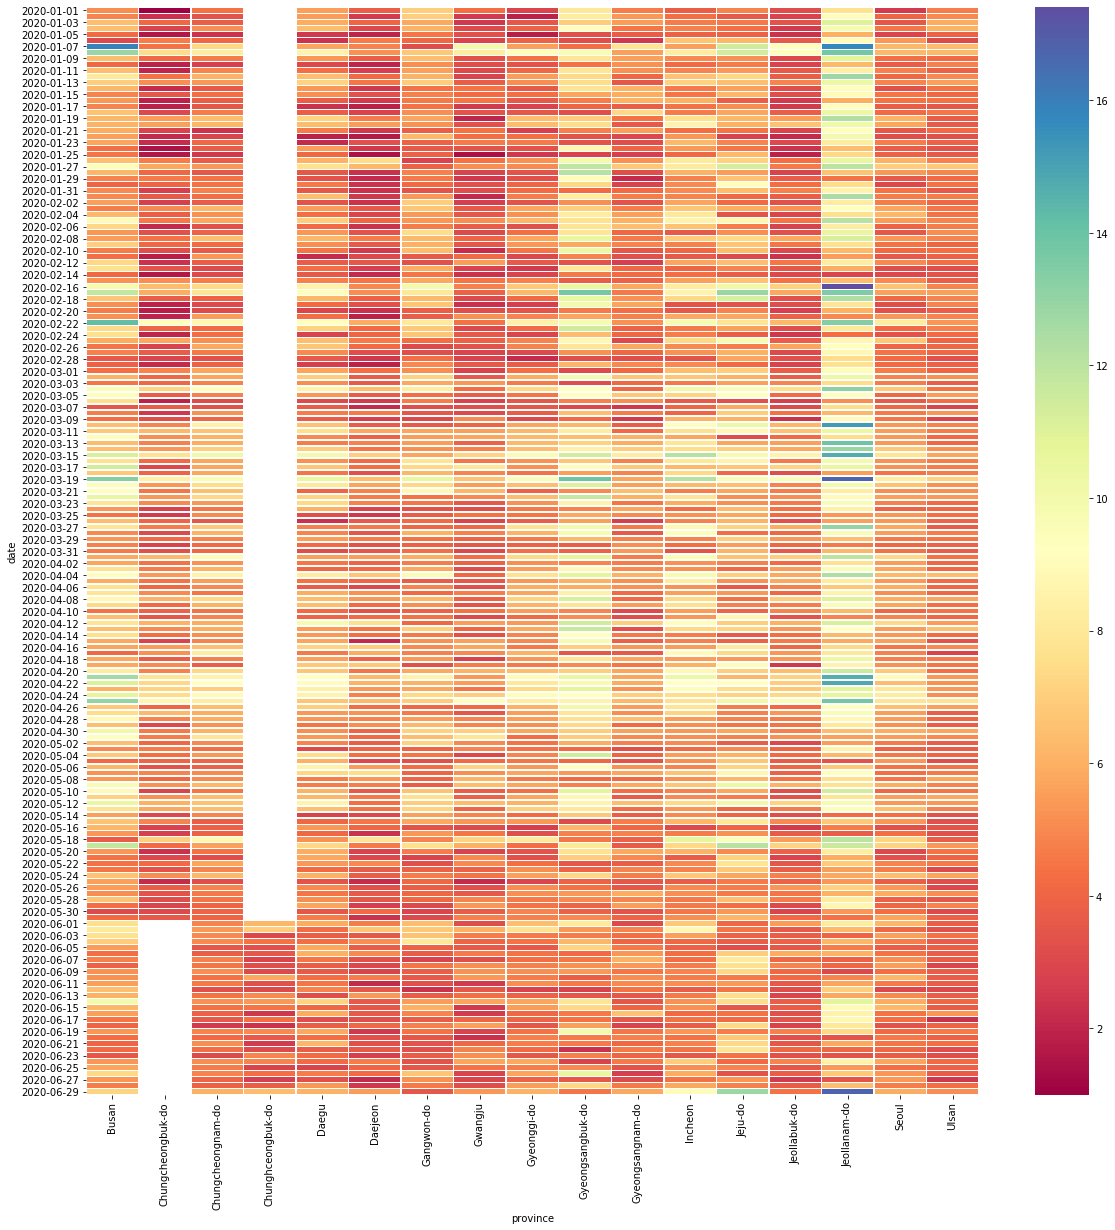

In [65]:
weatherDataForHeatmap = weatherData.pivot("date", "province", "max_wind_speed")
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(weatherDataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

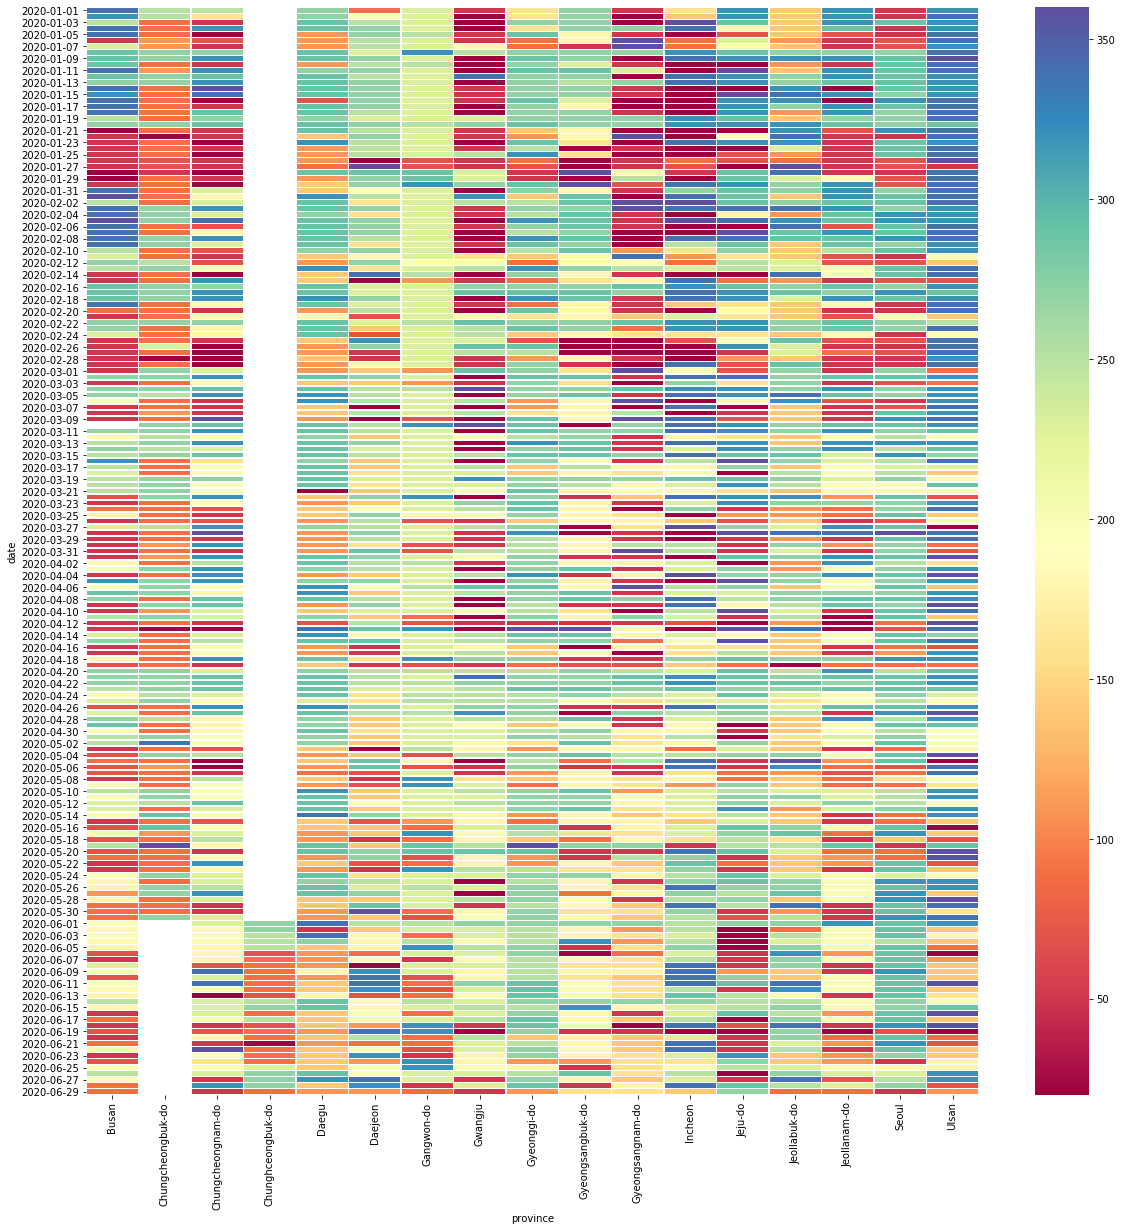

In [70]:
weatherDataForHeatmap = weatherData.pivot("date", "province", "most_wind_direction")
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(weatherDataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

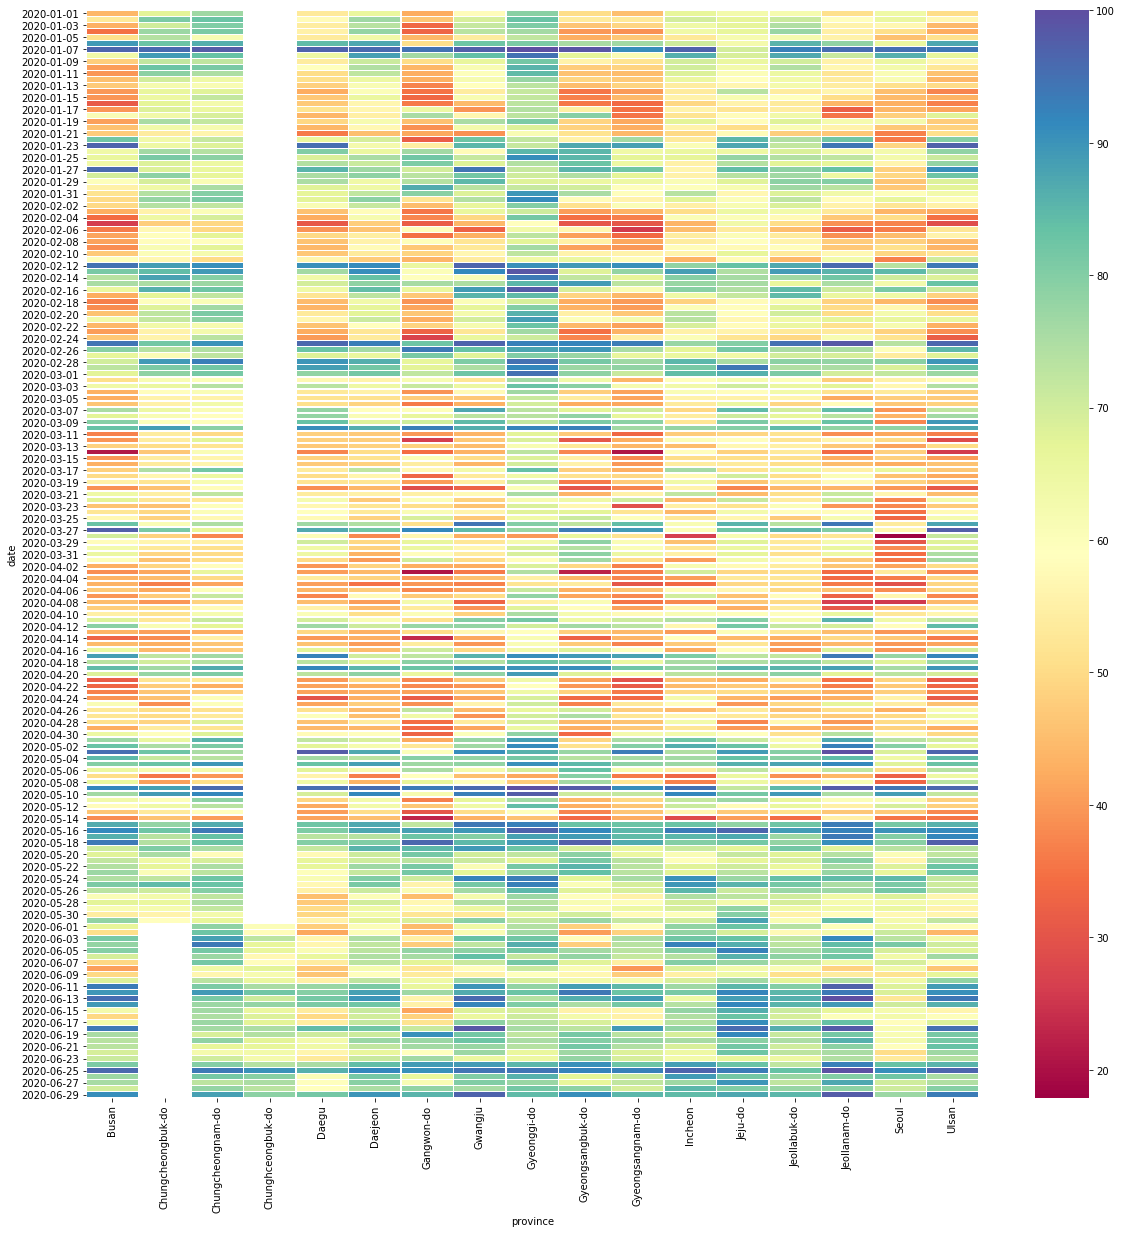

In [71]:
weatherDataForHeatmap = weatherData.pivot("date", "province", "avg_relative_humidity")
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(weatherDataForHeatmap, cmap="Spectral", annot=False, fmt="d", linewidths=.5, ax=ax)

# 1.9) Region

In [54]:
regionData = pd.read_csv('covid/region.csv')
pd.set_option('display.max_rows', regionData.shape[0]+1)
display(regionData.head())

fig = px.scatter_mapbox(
    regionData[regionData.city != 'Korea'], 
    text="city",
    lat="latitude", 
    lon="longitude",     
    color="elderly_population_ratio", 
    size="nursing_home_count",
    color_continuous_scale=px.colors.diverging.Spectral, 
    size_max=100, 
    zoom=6)
fig.show()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [80]:
regionData['Total School Count'] = regionData['elementary_school_count'] + regionData['kindergarten_count'] + regionData['university_count']
display(regionData.head())

fig = px.scatter_mapbox(
    regionData[regionData.city != 'Korea'], 
    text="city",
    lat="latitude", 
    lon="longitude",     
    color="Total School Count", 
    size="Total School Count",
    color_continuous_scale=px.colors.diverging.Spectral, 
    size_max=100, 
    zoom=6)
fig.show()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,Total School Count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739,1485
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088,71
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023,59
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628,35
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080,93
